In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
import numpy as np
import pandas as pd

# Libraries for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn cross validation and split the dataset
from sklearn.model_selection import train_test_split, cross_validate

# Sklearn utils and pipelines
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn_pandas import DataFrameMapper 
from sksurv.util import Surv

# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sksurv.ensemble import ExtraSurvivalTrees, RandomSurvivalForest, GradientBoostingSurvivalAnalysis

# Statsmodels for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Implementation of the XGBoost
import xgboost as xgb

# Lifelines for survival analysis
from lifelines.plotting import qq_plot
from lifelines import KaplanMeierFitter, WeibullFitter, WeibullAFTFitter, CoxPHFitter
from lifelines.utils import concordance_index

# For building the networks and some useful functions
import torch  
import torchtuples as tt 
from summarytools import dfSummary

# Deep learning for survival analysis
# from pycox.models import DeepHitSingle
# from pycox.evaluation import EvalSurv

In [3]:
df = pd.read_csv('churn_survival.csv')

In [ ]:
# https://www.kaggle.com/code/caralosal/survival-models-vs-ml-models-benchmark-churn-tel/notebook

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,customerID[object],1. 7590-VHVEG2. 3791-LGQCY3. 6008-NAIXK4. 5956-YHHRX5. 5365-LLFYV6. 5855-EIBDE7. 8166-ZZTFS8. 0129-KPTWJ9. 9128-CPXKI10. 9509-MPYOD11. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)7,033 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAACzCAYAAACHOUI0AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAACCklEQVR4nO3asW3EMBQFQVJwyFS4Ds71uAL17dx1yDWcEmKBmQoILPADPc37vgdNx+4H8Jx4YeKFiRcmXph4YeKFHXPO792P4JljjPHe/QiecTbDxAsTL0y8MPHCxAsTL0y8MPHCxAs7xhi/ux/BM9MPSF3OZphJKMwkFOZshokXJl6YeGHihYkXJl6YeGHihYkXZhIKMwmFOZthJqEwk1CYsxkmXph4YeKFiRcmXph4YeKFiRcmXphJKMwkFOZshpmEwkxCYc5mmHhh4oWJFyZemHhh4oWJFyZemHhhJqEwk1CYsxlmEgozCYU5m2HihYkXJl6YeGHihYkXJl6YeGHihZmEwkxCYc5mmEkozCQU5myGiRcmXph4YeKFiRcmXph4YeKFiRdmEgozCYU5m2EmoTCTUJizGSZemHhh4oWJFyZemHhh4oWJFyZemEkozCQU5myGmYTCTEJhzmaYeGHihYkXJl6YeGHihYkXJl6YeGHihdnzwux5Yc5mmD0vzJ4X5myGiRcmXph4YeKFiRcmXph4YeKFiRdmEgozCYU5m2EmoTCTUJizGSZemHhh4oWJFyZemHhh4oWJFyZemEkozCQU5myGzfM8f9Zar90P4XNfa63XdV1/ux/C55zNMPHCxAsTL0y8MPHCxAsTL0y8MPHCfNsMMwmFOZth4oWJFyZemHhh4oX9A5gQNK7t5DBkAAAAAElFTkSuQmCC"">",0(0.0%)
2,gender[object],1. Male2. Female,"3,555 (50.5%)3,488 (49.5%)",,0(0.0%)
3,SeniorCitizen[int64],Mean (sd) : 0.2 (0.4)min < med < max:0.0 < 0.0 < 1.0IQR (CV) : 0.0 (0.4),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA1klEQVR4nO3cuwkDMRAAUZ9xuLEucFWuQLWpAlflwIqVyxUIDk7n38xLBWJhYMNdeu8n/b/zpwfQe1xGDymlW0SsWz5prT1rrfd5Y2m2YeiIWHPOjy2flFKu80bSEVzdEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA0xvEqk77L3HJihf8Tec2CubghDQxgawtAQhoYwNIShIV7x5xvfcbBU6QAAAABJRU5ErkJggg=="">",0(0.0%)
4,Partner[object],1. No2. Yes,"3,641 (51.7%)3,402 (48.3%)",,0(0.0%)
5,Dependents[object],1. No2. Yes,"4,933 (70.0%)2,110 (30.0%)",,0(0.0%)
6,tenure[int64],Mean (sd) : 32.4 (24.6)min < med < max:0.0 < 29.0 < 72.0IQR (CV) : 46.0 (1.3),73 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAABS0lEQVR4nO3asU3DQBhAYYOQ3BytU9AgLwALZAgmuJa1PAFTsAcNBa7dWLJkFojDXWI7xu99bSzrpKf8uuTubhzHQvt3f+sFaB0PUx9UVfUWQjikvKTrup+2bT/mW5bmNhk6hHCIMX6nvKRpmqf5lqQlOLohDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGmLy9Erbcu2xsaH/iWuPjR3dEIaGMDSEoSEMDWFoCENDGBpilj9M+r5/rev6PeVZL/vfxiyhy7J89LL/tjm6IQwNYWgIQ0OsfkyZuUN/DiF8JT7rbv6M1UNn7tCPMcbPxGfdzZ+xm4sHW5gUObdActcxDMNLURRJX5BTdhN6C5Mi5xbIBes4pr73lN2EXkrOpLj2W7ckQ/8hd1IsvZ5L+fMKwtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaG+AU4vncUlIW1kgAAAABJRU5ErkJggg=="">",0(0.0%)
7,PhoneService[object],1. Yes2. No,"6,361 (90.3%)682 (9.7%)",,0(0.0%)
8,MultipleLines[object],1. No2. Yes3. No phone service,"3,390 (48.1%)2,971 (42.2%)682 (9.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAAAwCAYAAAAfHSRCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA30lEQVR4nO3ZsQnDMBBA0SikvFa4yFSZQLNpgkyVIq7VKxsYHGzkj/6b4ODDFXep934TU8o5vyJiGT3I0Vpr33Vd36PnONMjIpZSymf0IEertT5Hz3C2++gB9D/jgRkPzHhgxgMzHpjxwIwHZjww44EZD8zDNFjyJcTl2gRDr80ZVuMW9D9vhp/dFtcmmPHAjAdmPDDjgRkPzHhgxgMzHpjxwIwH5mEazH8emGsTbNfanH1NXc2uf97s/7OrcW2CGQ/MeGDGAzMemPHAjAdmPDDjgRkPzHhgHqbB/OeB/QAaRkjwRQx4oQAAAABJRU5ErkJggg=="">",0(0.0%)
9,InternetService[object],1. Fiber optic2. DSL3. No,"3,096 (44.0%)2,421 (34.4%)1,526 (21.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAAAwCAYAAAAfHSRCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA3ElEQVR4nO3ZsQ3CMBBAUYwor7VSZCom8GyegKkoSO3ezBAi43zlvwlO+tIVd6n3fhN

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# tenure = numero de meses que o clietnes sobreviveu
# churn, seria prepay

In [7]:
df = df.drop(index = df[df.loc[:, "TotalCharges"] == ' '].index)

In [8]:
df.Churn = df.Churn.replace({'Yes':1, 'No':0})

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,0.265785
std,0.368844,24.545260,30.085974,0.441782
min,0.000000,1.000000,18.250000,0.000000
25%,0.000000,9.000000,35.587500,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.862500,1.000000
max,1.000000,72.000000,118.750000,1.000000


In [29]:
def classification_metrics(y_test,
                     predictions,
                     labels = ['No', 'Yes'],
                     title = ''):
    
    """Function that calculates classification metrics for the churn problem.
    Params:
        o y_test: array containing the actual churn values of customers.
        o predictions: array containing the prediction of churn values of customers.
        o labels: labels to be shown in the heatmap of the confusion matrix
        o title: title that is displayed in the plot
    Output:
        o Metrics of the classification: accuracy, precision, recall, f1-score
        o Heatmap of the confusion matrix
    """

    # Some important metrics
    
    accuracy = round(100 * accuracy_score(y_test, predictions),2)
    precision = round(100 * precision_score(y_test, predictions),2)
    recall = round(100 * recall_score(y_test, predictions),2)
    f1 = round(100 * f1_score(y_test, predictions),2)
    
    print(f'Metrics of the classification {title}')
    print('=============================')
    print(f'Accuracy: {accuracy} %')
    print(f'Precision: {precision} %')
    print(f'Recall: {recall} %')
    print(f'F1-Score: {f1} %')
    print('=============================')

    # Perform the confusion matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # Matplotlib object
    plt.figure(figsize=(8,6), dpi=100)
    sns.set(font_scale = 1.1)

    # Heatmap of the confusion matrix
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(labels)

    # set y-axis label and ticks
    ax.set_ylabel("Actucal", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(labels)

    # set plot title
    ax.set_title("Confusion matrix " + title, fontsize=14, pad=20)

    plt.show()
    return accuracy, precision, recall, f1
  

def opt_prob(predictions,
             y_test,
             survival = False,
             min_tn = 500,
             min_tp = 10):
    
    """Function that performs
    Params:
        o y_test: array containing the actual churn values of customers.
        o predictions: array containing the prediction of churn values of customers.
        o survival: boolean that set if a value of min_tn and min_tp have to be ensure.
        o min_tn: minimum number of True Negatives that we accept as good. By default is 500 and only is used if survival = True
        o min_tp: minimum number of True Positives that we accept as good. By default is 10 and only is used if survival = True
    Output:
        o results: Dataset with probabilities, TN, TP, FN, FP sorted from higher sum of TN and TP to lower.
        o prob: probability threshold that optimizes the sum of True Positives and True Negatives
    """
    
    # Initialization of empty lists for true positives and negatives,
    # false positives and negatives, and the probabilities
    tp, tn, fp, fn, probs = [], [],[], [], []

    # A loop of all the probabilities that we want to set as threshold to infer that if it is Churn or not
    for i in np.linspace(0, 100, 500):

        preds = np.where(predictions > i / 100, 0, 1)
        tn_, fp_, fn_, tp_ = confusion_matrix(y_test, preds).ravel()
        tp.append(tp_)
        tn.append(tn_)
        fp.append(fp_)
        fn.append(fn_)
        probs.append(i)

    # Dataframe with all the results
    results = pd.DataFrame({'probs' : probs,
                 'tp' : tp,
                 'fp' : fp,
                 'fn' : fn,
                 'tn' : tn})
    
    # In some survival models, the result that optimizes the sum of TP and TN is the 
    # Naive model that predicts all customers as 0 (not leaving the company).
    # This forces the selection of a different model than the Naive one, thereby ensuring TP > 0.
    if survival:
        results = results[(results.loc[:, "tp"] > min_tp) & (results.loc[:, "tn"] > min_tn)]

    # Perform the sum of True Positive and True Negatives
    results['tp+tn'] = results.loc[:,'tp'] + results.loc[:,'tn']
    
    # Sort by the sum of TP+TN
    results = results.sort_values(by = 'tp+tn', ascending = False)

    return results, results.head(1).loc[:, 'probs'].values[0]


def histogram(df, col1, col2, col3, hue = 'Churn'):

    """Function that creates histograms for three selected variables from a dataframe in three graphs.
    Params:
        o df: pandas dataframe with the columns col1, col2, col3 and hue
        o col1: string name of the column belonging to the dataframe df for
                which the first histogram is to be generated.
        o col2: string name of the column belonging to the dataframe df for
                which the second histogram is to be generated.
        o col3: string name of the column belonging to the dataframe df for
                which the third histogram is to be generated.
        o hue: string name of the column belonging to the dataframe for 
               which color-based grouping is to be performed
    Output:
        o Histogram of three features of a dataframe
    """

    # Create the graph object
    (fig, ax) = plt.subplots(1, 3, figsize = (12,4))

    # First histogram
    sns.histplot(data = df, x = col1, hue = hue, ax = ax[0])
    ax[0].set_title(col1)

    # Second histogram
    sns.histplot(data = df, x = col2, hue = hue, ax = ax[1])
    ax[1].set_title(col2)

    # Third histogram
    sns.histplot(data = df, x = col3, hue = hue, ax = ax[2])
    ax[2].set_title(col3)

    plt.show()

In [12]:
# Target and explanatory variables selected after EDA
var_target = 'Churn'

var_explanatory = ['Partner', 'SeniorCitizen', 'tenure', 'OnlineSecurity', 'PaperlessBilling',
                    'PaymentMethod','MonthlyCharges', 'Contract'] + [var_target]

# Dataset that we are going to use
X = df[var_explanatory].copy()
y = X.pop(var_target)

# In lifelines, we have problems with tenure equals to 0. We have to replace with a small value
X.loc[X.loc[:, "tenure"] == 0, 'tenure'] = 0.001

# We perform OneHotEncoder for categorical features and StandardScaler for numerical
numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(X)
numerical_preprocessor = StandardScaler()

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# We specify the preprocessor for categorical and numerical columns
preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

# Split in train and test, stratify by Churn (so we have the same distribution for train and test)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

# Check the stratify and dimensions of train and test
print(f'Dimensions of train dataset: {X_train.shape}')
print(f'Dimensiones of test dataset: {X_test.shape}')
print(f'Percentage of churn in train: {round(100 * (y_train[y_train == 1].shape[0] / len(y_train)),2)} %')
print(f'Percentage of churn in test: {round(100 * (y_test[y_test == 1].shape[0] / len(y_test)),2)} %')

Dimensions of train dataset: (5625, 8)
Dimensiones of test dataset: (1407, 8)
Percentage of churn in train: 26.58 %
Percentage of churn in test: 26.58 %


### Log Reg

The mean cross-validation accuracy for Logistic Regression is: 0.794 ± 0.011
Metrics of the classification - Logistic Regression
Accuracy: 80.81 %
Precision: 65.03 %
Recall: 60.16 %
F1-Score: 62.5 %


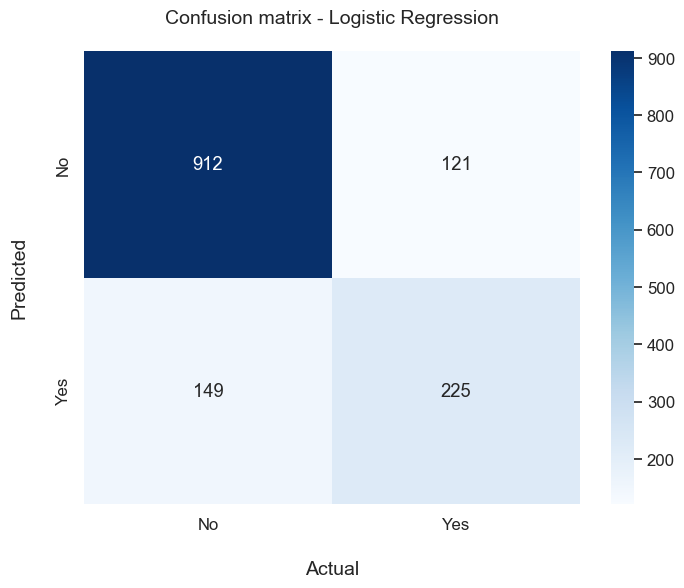

In [14]:
log_reg = make_pipeline(preprocessor, LogisticRegression(max_iter=500 ,
                                                         random_state=33))
# Train the model
log_reg.fit(X_train, y_train)

# Cross-validation to check for overfitting
cv_results = cross_validate(log_reg, X_train, y_train, cv=5)
scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy for Logistic Regression is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

# Predict the test set and return the probabilities
predicciones_log_reg = log_reg.predict_proba(X_test)

# Get the optimal threshold and the classification that maximizes the sum of TP and TN
log_reg_clasificacion, prob = opt_prob(predicciones_log_reg[:,0], y_test)

# With the optimal threshold, we get the final predictions
predicciones_log_reg = np.where(predicciones_log_reg[:,0] > prob / 100, 0, 1)

# Get all the metrics and confussion matrix
accuracy_log_reg, precision_log_reg, recall_log_reg, f1_score_log_reg = \
    classification_metrics(y_test.values, predicciones_log_reg, title = '- Logistic Regression')

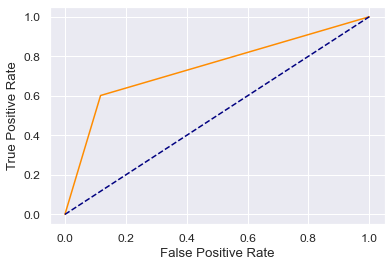

In [17]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plot_roc_curve(y_test.values, predicciones_log_reg)

### Survival

##### ----------Kaplan Meier (Nao Parametrico)------------

é uma estatística não paramétrica usada para estimar a função de sobrevivência a partir de dados de vida. Na pesquisa médica, é frequentemente usado para medir a fração de pacientes que vivem por um determinado período de tempo após o tratamento.

##### ----------Weibull (Parametrico)---------------------

Weibull é um modelo paramétrico, o que significa que possui uma forma funcional com parâmetros aos quais ajustamos os dados, portanto estamos assumindo uma distribuição para a função de sobrevivência.

##### ----------COX (Semi-Parametrico)--------------------

Mix 

In [ ]:
#kaplan meier

In [18]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df.tenure, event_observed=df.Churn)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7032 total observations, 5163 right-censored observations>

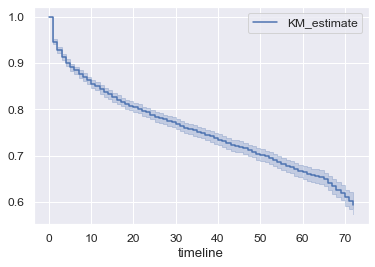

In [19]:
kmf.plot()
plt.show()

In [20]:
df.tenure.describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

Por exemplo, em 20 meses, temos 80% de probabilidade de não ocorrer o evento Churn. Em outras palavras, há 80% de chance de ainda estarmos na empresa em 20 meses e 20% de probabilidade de termos saído

P(churn)=1-p(survival)

In [ ]:
#weibull sem covariaveis

# X = MOB
# Y = EVENTO

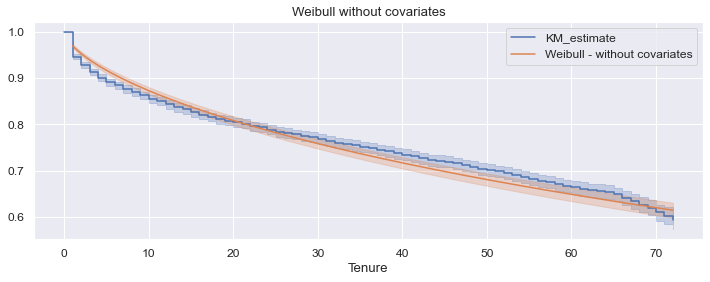

In [21]:
wb = WeibullFitter(label="Weibull - without covariates")
T = X_train['tenure'] # durations
E = y_train # event

# Adjust the data to Kaplan Meier and Weibull to check the model visually if the Weibull function
# fits the real data (which is de Kaplan Meier estimator)
wb.fit(T, E)
kmf.plot(figsize = (12,4))
wb.plot_survival_function()
plt.title(f'Weibull without covariates')
plt.xlabel('Tenure')
plt.show()

Metrics of the classification - Weibull without Covariates
Accuracy: 31.13 %
Precision: 13.5 %
Recall: 29.41 %
F1-Score: 18.5 %


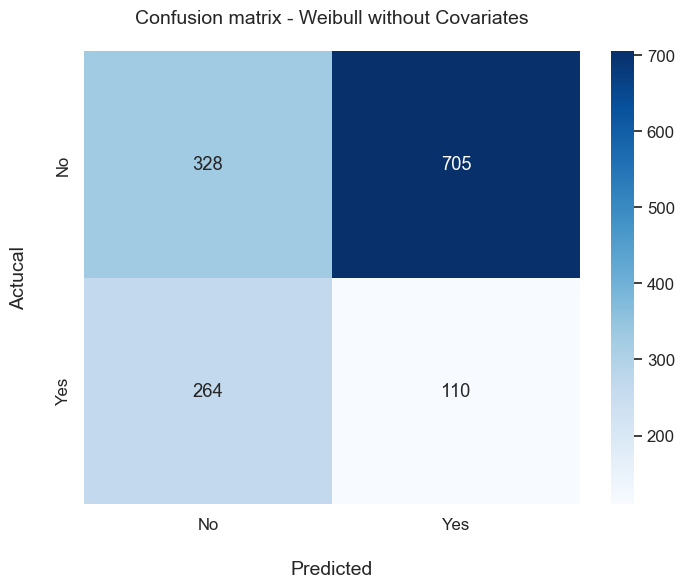

In [32]:
predicciones_wb_prob = pd.Series([wb.predict(year) for year in X_test.tenure])
wb_clasificacion, prob = opt_prob(predicciones_wb_prob,
                                  y_test,
                                  survival = True,
                                  min_tp = 100,
                                  min_tn = 100) 

# With the optimal threshold, we get the final predictions
predicciones_wb = np.where(predicciones_wb_prob > prob / 100, 0, 1)

# Get all the metrics and confussion matrix
accuracy_wb, precision_wb, recall_wb, f1_score_wb = \
    classification_metrics(y_test.values, predicciones_wb, title = '- Weibull without Covariates')

<AxesSubplot:xlabel='prob', ylabel='Count'>

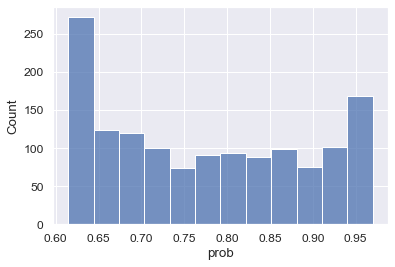

In [38]:
predicciones_wb_prob1 = pd.DataFrame(predicciones_wb_prob,columns=['prob'])
sns.histplot(data=predicciones_wb_prob1,x='prob')

In [ ]:
# weibull - com covariaveis

In [45]:
wb_aft = WeibullAFTFitter() 

In [ ]:
# se nao usar formula, tem q fazer dummies

Formula: Partner + SeniorCitizen + OnlineSecurity + PaperlessBilling + PaymentMethod + MonthlyCharges + Contract


<lifelines.WeibullAFTFitter: fitted with 5625 total observations, 4130 right-censored observations>
             duration col = 'tenure'
                event col = 'Event'
   number of observations = 5625
number of events observed = 1495
           log-likelihood = -7269.09
         time fit was run = 2023-09-07 17:53:40 UTC

---
                                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                        
lambda_ Intercept                                  3.54      34.54       0.15             3.25             3.83                25.91                46.03
        Partner[T.Yes]                             0.65       1.91       0.06             0.52             0.77                 1.68                 2.16
        SeniorCitizen                             -0.01       0.99       0.07            -0.15             0.13                 0.86                 1.14
        OnlineSecurity[T.No internet service]      1.12       3.08       0.16             0.82             1.43                 2.26                 4.19
        OnlineSecurity[T.Yes]                      0.78       2.18       0.08             0.61             0.95                 1.84                 2.57
        PaperlessBilling[T.Yes]                   -0.19       0.82       0.07            -0.34            -0.05                 0.71                 0.95
        PaymentMethod[T.Credit card (automatic)]   0.07       1.08       0.12            -0.15             0.30                 0.86                 1.35
        PaymentMethod[T.Electronic check]         -0.75       0.47       0.09            -0.93            -0.57                 0.39                 0.56
        PaymentMethod[T.Mailed check]             -0.69       0.50       0.11            -0.91            -0.47                 0.40                 0.62
        MonthlyCharges                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        Contract[T.One year]                       1.99       7.28       0.11             1.76             2.21                 5.84                 9.08
        Contract[T.Two year]                       3.40      29.83       0.20             3.01             3.79                20.19                44.05
rho_    Intercept                                 -0.14       0.87       0.02            -0.18            -0.10                 0.83                 0.91

                                                   cmp to     z      p   -log2(p)
param   covariate                                                                
lambda_ Intercept                                    0.00 24.17 <0.005     426.39
        Partner[T.Yes]                               0.00 10.16 <0.005      78.16
        SeniorCitizen                                0.00 -0.15   0.88       0.19
        OnlineSecurity[T.No internet service]        0.00  7.15 <0.005      40.07
        OnlineSecurity[T.Yes]                        0.00  9.16 <0.005      64.12
        PaperlessBilling[T.Yes]                      0.00 -2.66   0.01       6.98
        PaymentMethod[T.Credit card (automatic)]     0.00  0.64   0.52       0.94
        PaymentMethod[T.Electronic check]            0.00 -8.29 <0.005      53.01
        PaymentMethod[T.Mailed check]                0.00 -6.21 <0.005      30.81
        MonthlyCharges                               0.00  3.80 <0.005      12.77
        Contract[T.One year]                         0.00 17.66 <0.005     229.32
        Contract[T.Two year]                         0.00 17.06 <0.005     214.49
rho_    Intercept                                    0.00 -6.53 <0.005      33.78
---
Concordance = 0.85
AIC = 14564.17
log-likelihood ratio test = 2385.01 on 11 df
-log2(p) of ll-ratio test = inf

None

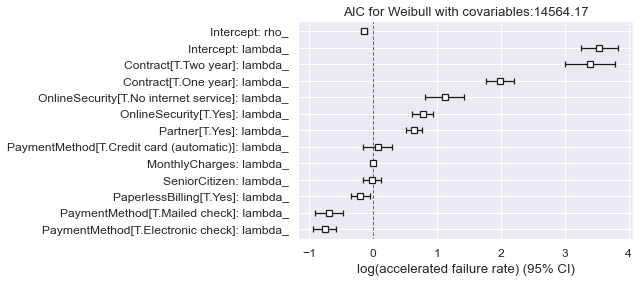

In [46]:
# The 'object' columns must be converted to 'categorical' if we want to use the 'formula' parameter
# in the training of the model
str_cols = X_train.dtypes[X_train.dtypes == 'object'].index
X_train[str_cols] = X_train[str_cols].astype('category')
X_test[str_cols] = X_test[str_cols].astype('category')

# If we don't use the formula, categorical variables need to be entered into the model as dummies,
# which would considerably increase the dataset's dimensionality
formula = ' + '.join(X_train.columns.tolist())
formula = formula.replace('+ tenure ', '')
print(f'Formula: {formula}')

# Unlike previous sklearn models, we need a single dataframe containing both the target and 
# explanatory variables.
X_train.loc[:, "Event"] = y_train.values

# Adjust the Weibull AFT (with covariates)
wb_aft.fit(df = X_train, duration_col = 'tenure', event_col = 'Event', formula = formula)

# Summary of the trained model
display(wb_aft.print_summary())

# Contribution of each variable to the model.
wb_aft.plot()
plt.title(f'AIC for Weibull with covariables:{round(wb_aft.AIC_,2)}')
plt.show()

The mode of the Contract variable is: Month-to-month


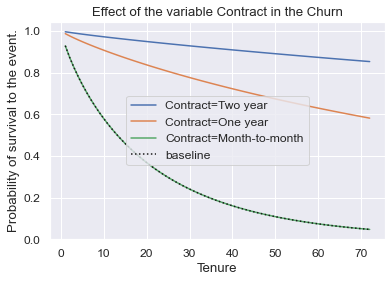

In [50]:
print(f'The mode of the Contract variable is: {X_train.Contract.mode()[0]}')
wb_aft.plot_partial_effects_on_outcome(covariates = 'Contract',
                                       values = X_train.Contract.unique().tolist())
plt.title('Effect of the variable Contract in the Churn')
plt.xlabel('Tenure')
plt.ylabel('Probability of survival to the event.')
plt.show()

In [ ]:
# Este é o caso de uma variável categórica. Vemos que a linha de base (com traços) se sobrepõe à curva quando o contrato é igual a 'Mês a mês' porque é a moda da variável Contrato. 
# O que observamos no gráfico anterior é a variação da curva de sobrevivência em relação ao linha de base quando a variável contrato assume os valores ‘Um ano’ e ‘Dois anos’. 
# O que se nota é uma diminuição significativa no risco de rotatividade. Por exemplo, aos 40 meses, a probabilidade de sobrevivência 
# (ou seja, de não ter mudado) para contratos “mês a mês” é de aproximadamente 18% 
# (o que significa que há uma probabilidade de 82% de ter mudado até esse mês). 
# Pelo contrário, se o contrato mudar para 'Um ano', observamos uma mudança substancial na curva de sobrevivência, e a probabilidade de sobrevivência no mês 40 aumenta para cerca de 70%.
# Por fim, se a variável contrato for definida como ‘Dois anos’, a probabilidade de sobrevivência (não sair da empresa) até o 40º mês sobe para 90%.

The median of the variable MonthlyCharges es: 70.35


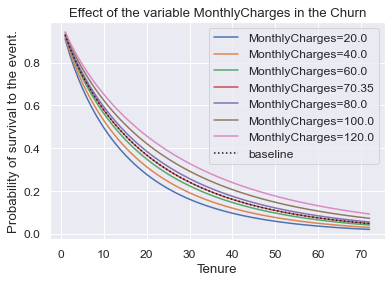

In [51]:
print(f'The median of the variable MonthlyCharges es: {X_train.MonthlyCharges.median()}')
wb_aft.plot_partial_effects_on_outcome(covariates = 'MonthlyCharges',
                                       values = [20, 40, 60,X_train.MonthlyCharges.median(),
                                                 80, 100, 120])

plt.title('Effect of the variable MonthlyCharges in the Churn')
plt.xlabel('Tenure')
plt.ylabel('Probability of survival to the event.')
plt.show()

<!-- O gráfico anterior mostra algo bastante semelhante, mas neste caso, com uma variável numérica contínua. Neste caso, a linha de base coincide com a mediana da variável MonthlyCharges (neste caso, com valor de 70,35). O que se observa é o efeito da variação da curva de sobrevivência em relação ao valor mediano. Percebe-se que quando a variável MonthlyCharges assume um valor inferior à mediana, a curva de sobrevivência permanece abaixo, implicando em maior risco de rotatividade de clientes. Por outro lado, os clientes que pagam mais têm menor probabilidade de sair, com as suas curvas de sobrevivência posicionadas acima. -->

In [ ]:
# Como cada combinação de covariáveis resulta em uma curva de sobrevivência diferente,
# prevemos a curva de sobrevivência de cada cliente (com as covariáveis que eles possuem),
# e depois acessar o número de meses que estão na empresa (manage),
# o que nos dará a probabilidade de ter sobrevivido ao evento Churn.

Metrics of the classification - Weibull with Covariates
Accuracy: 67.24 %
Precision: 37.39 %
Recall: 34.49 %
F1-Score: 35.88 %


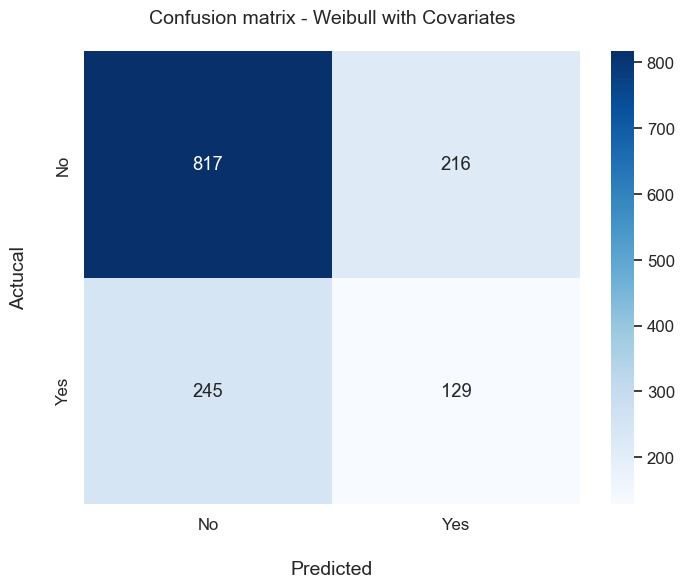

In [55]:
survival_curves = wb_aft.predict_survival_function(X_test)
predicciones_wb_aft = np.zeros(len(y_test))
for i, identifier in enumerate(survival_curves):
    predicciones_wb_aft[i] = survival_curves.loc[X_test.loc[identifier, 'tenure'], identifier]

predicciones_wb_aft_prob = predicciones_wb_aft.copy()
    
# Get the optimal threshold and the classification that maximizes the sum of TP and TN
wb_aft_clasificacion, prob = opt_prob(predicciones_wb_aft,
                                  y_test,
                                  survival = True,
                                  min_tp = 100)

# With the optimal threshold, we get the final predictions
predicciones_wb_aft = np.where(predicciones_wb_aft > prob / 100, 0, 1)

# Get all the metrics and confussion matrix
accuracy_wb_aft, precision_wb_aft, recall_wb_aft, f1_score_wb_aft = \
    classification_metrics(y_test.values, predicciones_wb_aft, title = '- Weibull with Covariates')

# Concordance index
concordance_index_train_wb_aft = round(wb_aft.concordance_index_,6)

concordance_index_test_wb_aft = round(concordance_index(X_test.tenure.values,
                                                          predicciones_wb_aft_prob,
                                                          y_test.values),
                                        6)

In [ ]:
#Survival tree

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)

# For this library, we need a specific format of the target variable with a 
# numpy.array of tuples. The first element with the event (True or false) and
# the secod element with the time of the event.
y_sksurv = Surv().from_arrays(y_train.values, X_train.tenure.values)

X_sksurv = X_train[['Partner', 'SeniorCitizen', 'tenure', 'OnlineSecurity', 'PaperlessBilling',
                    'PaymentMethod','MonthlyCharges', 'Contract']]

# We perform OneHotEncoder for categorical features and StandardScaler for numerical
numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(X_sksurv)
numerical_preprocessor = StandardScaler()

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X_sksurv)
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

# We specify the preprocessor
preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

# Train all the based tree models of the library to benchmark
extra_tree = make_pipeline(preprocessor, ExtraSurvivalTrees(random_state = 33,
                                                           max_depth = 35))

survival_forest = make_pipeline(preprocessor, RandomSurvivalForest(random_state = 33,
                                                           max_depth = 35))

gradient_forest = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(random_state = 33,
                                                           loss = 'coxph',
                                                           learning_rate = 0.05))
# Fit all the models
extra_tree.fit(X_sksurv, y_sksurv)
survival_forest.fit(X_sksurv, y_sksurv)
gradient_forest.fit(X_sksurv, y_sksurv)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Partner', 'OnlineSecurity',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'Contract']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges'])])),
                ('gradientboostingsurvivalanalysis',
                 GradientBoostingSurvivalAnalysis(learning_rate=0.05,
                                                  random_state=33))])

In [ ]:
# Survival Forest

Metrics of the classification - Random Tree
Accuracy: 77.9 %
Precision: 70.06 %
Recall: 29.41 %
F1-Score: 41.43 %


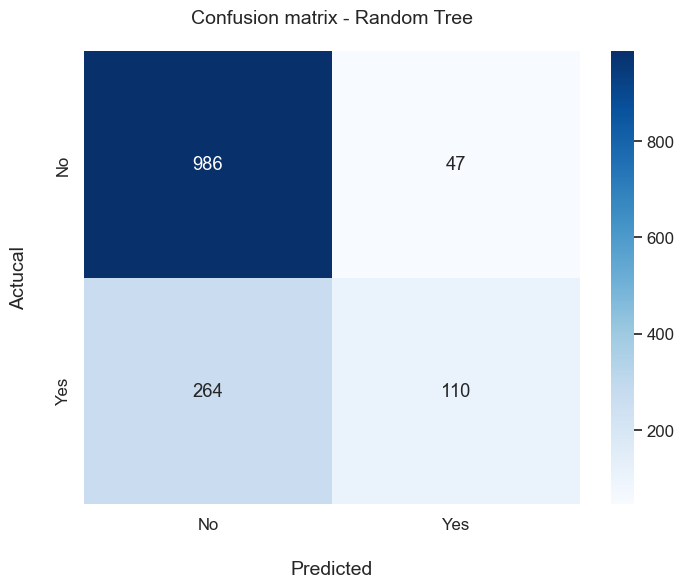

In [57]:
results = survival_forest.predict_survival_function(X_test)
survival_random_tree = []
for i in range(len(results)):
    survival_random_tree.append(results[i].y[int(X_test.tenure.iloc[i]) - 1])

survival_random_tree_prob = survival_random_tree.copy()    

# Get the optimal threshold and the classification that maximizes the sum of TP and TN
survival_random_tree_clasificacion, prob = opt_prob(survival_random_tree,
                                             y_test,
                                             survival = True,
                                             min_tp = 100)

# With the optimal threshold, we get the final predictions
predicciones_random_tree = np.where(survival_random_tree > prob / 100, 0, 1)

# Get all the metrics and confussion matrix
accuracy_surv_forest, precision_surv_forest, recall_surv_forest, f1_score_surv_forest = \
    classification_metrics(y_test.values, predicciones_random_tree, title = '- Random Tree')

# Concordance index
concordance_index_test_survival_tree = round(concordance_index(X_test.tenure.values,
                                                          survival_random_tree_prob,
                                                          y_test.values),
                                        6)

In [ ]:
#Gradient tree

Metrics of the classification - Gradient Tree
Accuracy: 76.05 %
Precision: 56.68 %
Recall: 41.98 %
F1-Score: 48.23 %


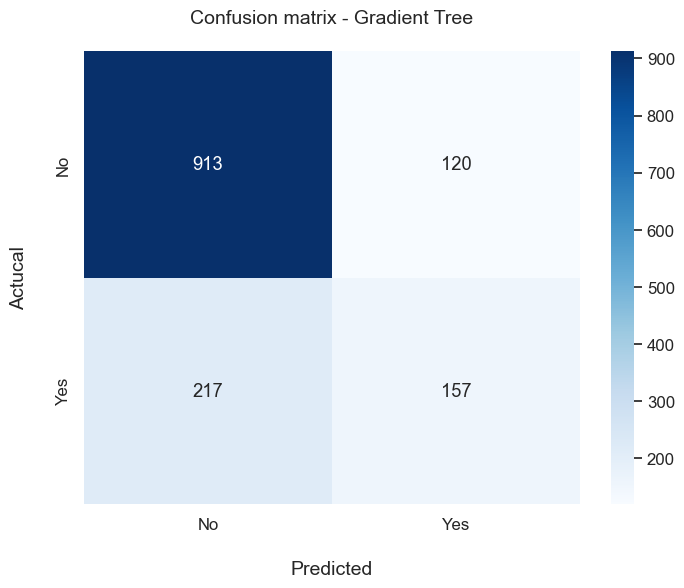

In [58]:
results = gradient_forest.predict_survival_function(X_test)
survival_gradient_tree = []
for i in range(len(results)):
    survival_gradient_tree.append(results[i].y[int(X_test.tenure.iloc[i]) - 1])
    
survival_gradient_tree_prob = survival_gradient_tree.copy()

# Get the optimal threshold and the classification that maximizes the sum of TP and TN
survival_gradient_tree_clasificacion, prob = opt_prob(survival_gradient_tree,
                                             y_test,
                                             survival = True,
                                             min_tp = 100)

# With the optimal threshold, we get the final predictions
predicciones_gradient_tree = np.where(survival_gradient_tree > prob / 100, 0, 1)

# Get all the metrics and confussion matrix
accuracy_grad_tree, precision_grad_tree, recall_grad_tree, f1_score_grad_tree = \
    classification_metrics(y_test.values, predicciones_gradient_tree, title = '- Gradient Tree')

# Concordance index
concordance_index_test_gradient_tree = round(concordance_index(X_test.tenure.values,
                                                          survival_gradient_tree_prob,
                                                          y_test.values),
                                        6)